# Test a single day of the full calculation

In [7]:
import cosima_cookbook as cc
import numpy as np
import netCDF4 as nc
import xarray as xr
from gsw import SA_from_SP, p_from_z, sigma1
import sys,os
from glob import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43149 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

#session_name = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db'
#easterlies_session = cc.database.create_session(session_name)

expt = '01deg_jra55v13_ryf9091_easterlies_down10'

###############################
#### get run count argument that was passed to python script ####

month = '2'
month = month.zfill(2)

year = '2150'

first_year = year
last_year = year

start_time=first_year+'-'+month+'-01'
end_time=last_year+'-'+month+'-02'

# reference density value:
rho_0 = 1035.0
lat_range = slice(-90,-59)



In [23]:
# If regional data coordinates are stuffed and need fixing:

#yt_ocean = cc.querying.getvar(expt, 'yt_ocean',session, n=1, ncfile = 'ocean_grid.nc')
#yt_ocean = yt_ocean[:511]
xt_ocean = cc.querying.getvar(expt, 'xt_ocean',session, n=1, ncfile = 'ocean_grid.nc')

path2files   = '/g/data/ik11/outputs/access-om2-01/'+expt+'/'
dataFileList = glob(os.path.join(path2files, 'output*/ocean/rregionocean_daily_3d_vhrho_nt.nc'))
dataFileList.sort()

for file in dataFileList:
    ncFile = nc.Dataset(file,'r+')
    # overwrite yt_ocean_sub01
    #ncFile.variables['yt_ocean_sub01'][...] = yt_ocean.values
    ncFile.variables['xt_ocean_sub01'][...] = xt_ocean.values
    ncFile.close()


In [24]:
dyt = cc.querying.getvar(expt, 'dyt',session, n=1, ncfile = 'ocean_grid.nc')
dxu = cc.querying.getvar(expt, 'dxu',session, n=1, ncfile = 'ocean_grid.nc')

# select latitude range:
dxu = dxu.sel(yu_ocean=lat_range)
dyt = dyt.sel(yt_ocean=lat_range)


In [25]:
isobath_depth = 1000
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']
mask_x_transport = data['mask_x_transport']
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_x_transport_numbered = data['mask_x_transport_numbered']

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [yt_ocean, xu_ocean], dims=['y_ocean', 'x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [yu_ocean, xt_ocean], dims=['y_ocean', 'x_ocean'])

# ### Stack contour data into 1D

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1,len(contour_ordering)+1)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean
# don't need the multi-index anymore, replace with contour count
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array


In [26]:
# issue here for down experiment:
vhrho = cc.querying.getvar(expt,'vhrho_nt',session,ncfile='%daily%')
uhrho = cc.querying.getvar(expt,'uhrho_et',session,ncfile='%daily%')

# the coords on regional variables might be wacky, in which case need to do:
vhrho = vhrho.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
uhrho = uhrho.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
# if meridional length is too long, cut to match:
vhrho = vhrho[:,:,:len(yt_ocean),:]
uhrho = uhrho[:,:,:len(yt_ocean),:]
vhrho.coords['yt_ocean'] = yt_ocean
uhrho.coords['yt_ocean'] = yt_ocean

# select latitude range and this month:
vhrho = vhrho.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))
uhrho = uhrho.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

# Note that vhrho is defined as the transport across the northern edge of a tracer cell so its coordinates 
#       should be (yu_ocean, xt_ocean).
#  uhrho is defined as the transport across the eastern edge of a tracer cell so its coordinates should 
#       be (yt_ocean, xu_ocean).
#  However we will keep the actual name as simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation and sorting possible.
yt_ocean = dyt.yt_ocean.values
yu_ocean = dxu.yu_ocean.values
xu_ocean = dxu.xu_ocean.values
xt_ocean = dyt.xt_ocean.values
vhrho.coords['yt_ocean'] = yu_ocean
uhrho.coords['xt_ocean'] = xu_ocean
vhrho = vhrho.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})
uhrho = uhrho.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'})

# ### Convert to transports 

# First we also need to change coords on dxu, dyt, so we can multiply the transports:
dyt = dyt.reset_coords().dyt # remove geolon_t/geolat_t coordinates
dxu = dxu.reset_coords().dxu # remove geolon_t/geolat_t coordinates
dxu.coords['xu_ocean'] = xt_ocean
dxu = dxu.rename({'yu_ocean':'y_ocean', 'xu_ocean':'x_ocean'}) 
dyt.coords['xt_ocean'] = xu_ocean
dyt = dyt.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})

# convert to transports and multiply by contour masks:
vhrho = vhrho*dxu*mask_y_transport/rho_0
uhrho = uhrho*dyt*mask_x_transport/rho_0


In [27]:
# ### Extract transport values along contour:

## initiate a empty dataarray
vol_trans_across_contour = xr.DataArray(np.zeros((len(uhrho.time),len(uhrho.st_ocean),len(contour_index_array))),
                                        coords = [uhrho.time,uhrho.st_ocean, contour_index_array],
                                        dims = ['time','st_ocean', 'contour_index'],
                                        name = 'vol_trans_across_contour')

# stack transports into 1d and drop any points not on contour:
x_transport_1d = uhrho.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = vhrho.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.load()

del uhrho, vhrho, x_transport_1d, y_transport_1d


In [9]:
# ### Extract salt along contour:

salt = cc.querying.getvar(expt,'salt',session,ncfile='%daily%')

# the coords on regional variables might be wacky, in which case need to do:
salt = salt.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
# if meridional length is too long, cut to match:
salt = salt[:,:,:len(yt_ocean),:]
salt.coords['yt_ocean'] = yt_ocean

salt = salt.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

# interpolate to correct grid:
salt = salt.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'}) 
salt_w = salt.copy()
salt_w.coords['x_ocean'] = xu_ocean
salt_e = salt.roll(x_ocean=-1)
salt_e.coords['x_ocean'] = xu_ocean
# salt_xgrid will be on the uhrho grid:
salt_xgrid = (salt_e + salt_w)/2

salt_s = salt.copy()
salt_s.coords['y_ocean'] = yu_ocean
salt_n = salt.roll(y_ocean=-1)
salt_n.coords['y_ocean'] = yu_ocean
# salt_ygrid will be on the vhrho grid:
salt_ygrid = (salt_s + salt_n)/2

# stack transports into 1d and drop any points not on contour:
salt_xgrid = salt_xgrid.where(mask_x_transport_numbered>0)
salt_ygrid = salt_ygrid.where(mask_y_transport_numbered>0)
x_salt_1d = salt_xgrid.stack(contour_index = ['y_ocean', 'x_ocean'])
y_salt_1d = salt_ygrid.stack(contour_index = ['y_ocean', 'x_ocean'])
x_salt_1d = x_salt_1d.where(mask_x_numbered_1d>0,drop=True)
y_salt_1d = y_salt_1d.where(mask_y_numbered_1d>0,drop=True)

# combine all points on contour:
salt_along_contour = xr.concat((x_salt_1d, y_salt_1d), dim = 'contour_index')
salt_along_contour = salt_along_contour.sortby(contour_ordering)
salt_along_contour.coords['contour_index'] = contour_index_array
salt_along_contour = salt_along_contour.load()

In [10]:
# ### Extract temp along contour:

temp = cc.querying.getvar(expt,'temp',session,ncfile='%daily%') - 273.15

# the coords on regional variables might be wacky, in which case need to do:
temp = temp.rename({'yt_ocean_sub01':'yt_ocean', 'xt_ocean_sub01':'xt_ocean'})
# if meridional length is too long, cut to match:
temp = temp[:,:,:len(yt_ocean),:]
temp.coords['yt_ocean'] = yt_ocean

temp = temp.sel(yt_ocean=lat_range).sel(time=slice(start_time,end_time))

# interpolate to correct grid:
temp = temp.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'}) 
temp_w = temp.copy()
temp_w.coords['x_ocean'] = xu_ocean
temp_e = temp.roll(x_ocean=-1)
temp_e.coords['x_ocean'] = xu_ocean
# temp_xgrid will be on the uhrho grid:
temp_xgrid = (temp_e + temp_w)/2

temp_s = temp.copy()
temp_s.coords['y_ocean'] = yu_ocean
temp_n = temp.roll(y_ocean=-1)
temp_n.coords['y_ocean'] = yu_ocean
# temp_ygrid will be on the vhrho grid:
temp_ygrid = (temp_s + temp_n)/2

# stack transports into 1d and drop any points not on contour:
temp_xgrid = temp_xgrid.where(mask_x_transport_numbered>0)
temp_ygrid = temp_ygrid.where(mask_y_transport_numbered>0)
x_temp_1d = temp_xgrid.stack(contour_index = ['y_ocean', 'x_ocean'])
y_temp_1d = temp_ygrid.stack(contour_index = ['y_ocean', 'x_ocean'])
x_temp_1d = x_temp_1d.where(mask_x_numbered_1d>0,drop=True)
y_temp_1d = y_temp_1d.where(mask_y_numbered_1d>0,drop=True)

# combine all points on contour:
temp_along_contour = xr.concat((x_temp_1d, y_temp_1d), dim = 'contour_index')
temp_along_contour = temp_along_contour.sortby(contour_ordering)
temp_along_contour.coords['contour_index'] = contour_index_array
temp_along_contour = temp_along_contour.load()

In [11]:
# ### Calculate density on contour:

time = salt_along_contour.time
st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1)
depth = -st_ocean.values
depth = xr.DataArray(depth, coords = [st_ocean], dims = ['st_ocean'])
depth_along_contour = (salt_along_contour[0,...]*0+1)*depth

pressure_along_contour = xr.DataArray(p_from_z(depth_along_contour,lat_along_contour), 
                                      coords = [st_ocean, contour_index_array], 
                                      dims = ['st_ocean','contour_index'], 
                                      name = 'pressure', attrs = {'units':'dbar'})

# absolute salinity:
abs_salt_along_contour = xr.DataArray(SA_from_SP(salt_along_contour,pressure_along_contour,
                                             lon_along_contour,lat_along_contour), 
                                  coords = [time,st_ocean,contour_index_array], 
                                  dims = ['time','st_ocean','contour_index'], 
                                  name = 'Absolute salinity', 
                                  attrs = {'units':'Absolute Salinity (g/kg)'})

sigma1_along_contour = xr.DataArray(sigma1(abs_salt_along_contour, temp_along_contour),
                                     coords = [time,st_ocean, contour_index_array], 
                                    dims = ['time','st_ocean', 'contour_index'], 
                                     name = 'potential density ref 1000dbar', 
                                    attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})

del salt_along_contour, temp_along_contour, pressure_along_contour, abs_salt_along_contour, depth_along_contour


In [73]:
# ### Bin into density:
## define isopycnal bins   
isopycnal_bins_sigma1 = np.append(np.append(np.append(1,np.arange(27,32,.1)),np.arange(32,32.8,.01)),40)

## intialise empty transport along contour in density bins array
vol_trans_across_contour_binned = xr.DataArray(np.zeros((len(isopycnal_bins_sigma1),len(contour_ordering))), 
                                               coords = [isopycnal_bins_sigma1, contour_index_array], 
                                               dims = ['isopycnal_bins', 'contour_index'], 
                                               name = 'vol_trans_across_contour_binned')

# loop through density bins:
for i in range(len(isopycnal_bins_sigma1)-1):
    #print(i)
    bin_mask = sigma1_along_contour.where(sigma1_along_contour<=isopycnal_bins_sigma1[i+1]).where(sigma1_along_contour>isopycnal_bins_sigma1[i])*0+1
    bin_fractions = (isopycnal_bins_sigma1[i+1]-sigma1_along_contour * bin_mask)/(isopycnal_bins_sigma1[i+1]-isopycnal_bins_sigma1[i])
    ## transport
    transport_across_contour_in_sigmalower_bin = (vol_trans_across_contour * bin_mask * bin_fractions).sum(dim = 'st_ocean')
    vol_trans_across_contour_binned[i,:] += transport_across_contour_in_sigmalower_bin.fillna(0).mean('time')
    del transport_across_contour_in_sigmalower_bin
    transport_across_contour_in_sigmaupper_bin = (vol_trans_across_contour * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
    vol_trans_across_contour_binned[i+1,:] += transport_across_contour_in_sigmaupper_bin.fillna(0).mean('time')
    del bin_mask, bin_fractions, transport_across_contour_in_sigmaupper_bin


(32.7, 32.2)

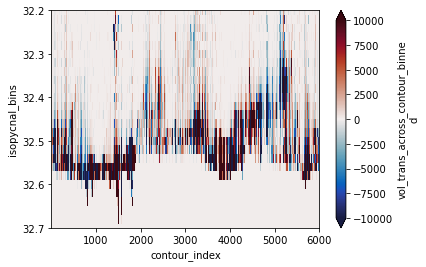

In [76]:
import cmocean.cm as cmocean
import matplotlib.pyplot as plt
vol_trans_across_contour_binned.plot(vmin=-10000,vmax=10000,cmap=cmocean.balance)
plt.ylim(32.7,32.2)
#plt.xlim(1400,1900)

(33.0, 32.0)

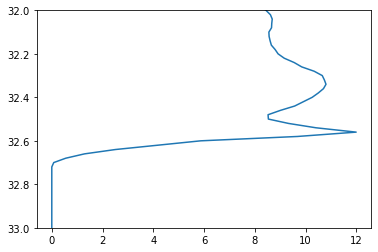

In [83]:
# sum along contour index:
trans_sum = vol_trans_across_contour_binned.sum('contour_index')

# sum vertically from bottom up:
psi = trans_sum[::-1].cumsum('isopycnal_bins')[::-1]
plt.plot(psi/1e6,psi.isopycnal_bins)
plt.ylim(33,32)

In [82]:
vol_trans_across_contour_binned.sum()

<xarray.DataArray 'vol_trans_across_contour_binned' ()>
array(126358.02522406)